In [1]:
import os

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

import egoviz.models.processing as pr
import egoviz.models.evaluation as ev

SEED = 42

In [2]:
# if df pkl exists, load it
cwd = os.getcwd()

try:
    file_path = os.path.join(cwd, '../data/home_data_all_preds_df.pkl')
    df = pr.load_pickle(file_path)

except FileNotFoundError:
    file_path = os.path.join(cwd, '../data/home_data_all_preds.pkl')
    data = pr.load_pickle(file_path)
    df = pd.DataFrame(columns=['video', 'frame', 'classes', 'active', 'adl'])

    for id, dets in data.items():
        adl = id.split('_', 1)[0]
        video = id.split('_')[1]
        frame = id.split('_')[2]
        classes = dets['remapped_metadata']
        active = dets['active_objects']

        row = {'video': video, 'frame': frame, 'classes': classes, 'adl': adl, 'active': active}

        df.loc[len(df)] = row

    # save df
    df.to_pickle(os.path.join(cwd, '../data/home_data_eval_all_preds_df.pkl'))

In [3]:
df_active = pr.generate_counts_df(df); df_active.head()

,video,adl,count_clothing_accessory,count_phone_tablet,count_other,count_office_stationary,count_footwear,count_furniture,active_office_stationary,active_furniture,...,count_house_fixtures,active_house_fixtures,count_tableware,active_tableware,count_bathroom_fixture,active_bathroom_fixture,count_plant,active_plant,count_hat,active_hat
0,SCI02-1--1,functional-mobility,0.0,6.0,7.0,13.0,3.0,10.0,0.0,0.0,...,20.0,0.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,SCI02-1--10,meal-preparation-cleanup,2.0,0.0,6.0,2.0,1.0,2.0,0.0,0.0,...,17.0,0.0,18.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
2,SCI02-1--11,meal-preparation-cleanup,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,17.0,0.0,25.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0
3,SCI02-1--12,meal-preparation-cleanup,0.0,0.0,8.0,3.0,0.0,4.0,0.0,0.0,...,15.0,0.0,21.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0
4,SCI02-1--2,meal-preparation-cleanup,10.0,4.0,6.0,2.0,1.0,2.0,0.0,0.0,...,35.0,1.0,8.0,0.0,11.0,0.0,3.0,0.0,0.0,0.0


In [4]:
df_no_active = df_active.drop(columns=[col for col in df_active.columns if 'active' in col]); df_no_active.head()

,video,adl,count_clothing_accessory,count_phone_tablet,count_other,count_office_stationary,count_footwear,count_furniture,count_furnishing,count_drinkware,...,count_musical_instrument,count_sink,count_cabinetry,count_kitchen_appliance,count_tv_computer,count_house_fixtures,count_tableware,count_bathroom_fixture,count_plant,count_hat
0,SCI02-1--1,functional-mobility,0.0,6.0,7.0,13.0,3.0,10.0,8.0,19.0,...,0.0,6.0,15.0,7.0,0.0,20.0,6.0,4.0,0.0,0.0
1,SCI02-1--10,meal-preparation-cleanup,2.0,0.0,6.0,2.0,1.0,2.0,3.0,18.0,...,0.0,15.0,1.0,3.0,0.0,17.0,18.0,6.0,0.0,0.0
2,SCI02-1--11,meal-preparation-cleanup,1.0,0.0,2.0,0.0,0.0,0.0,1.0,7.0,...,0.0,18.0,0.0,0.0,0.0,17.0,25.0,13.0,0.0,0.0
3,SCI02-1--12,meal-preparation-cleanup,0.0,0.0,8.0,3.0,0.0,4.0,2.0,28.0,...,0.0,14.0,10.0,2.0,0.0,15.0,21.0,7.0,1.0,0.0
4,SCI02-1--2,meal-preparation-cleanup,10.0,4.0,6.0,2.0,1.0,2.0,1.0,47.0,...,0.0,13.0,19.0,11.0,0.0,35.0,8.0,11.0,3.0,0.0


## Classifiers

In [5]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=500, random_state=SEED)

# Logistic Regression
log_clf = LogisticRegression(random_state=SEED)

## With Active Objects

2023-11-17 22:25:54,359 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI02
2023-11-17 22:25:55,993 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI03
2023-11-17 22:25:57,593 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI06
2023-11-17 22:25:59,296 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI08
2023-11-17 22:26:00,811 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI10
2023-11-17 22:26:02,380 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI11
2023-11-17 22:26:03,919 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI12
2023-11-17 22:26:05,520 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI13
2023-11-17 22:26:07,077 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI14
2023-11-17 22:26:08,672 - ro

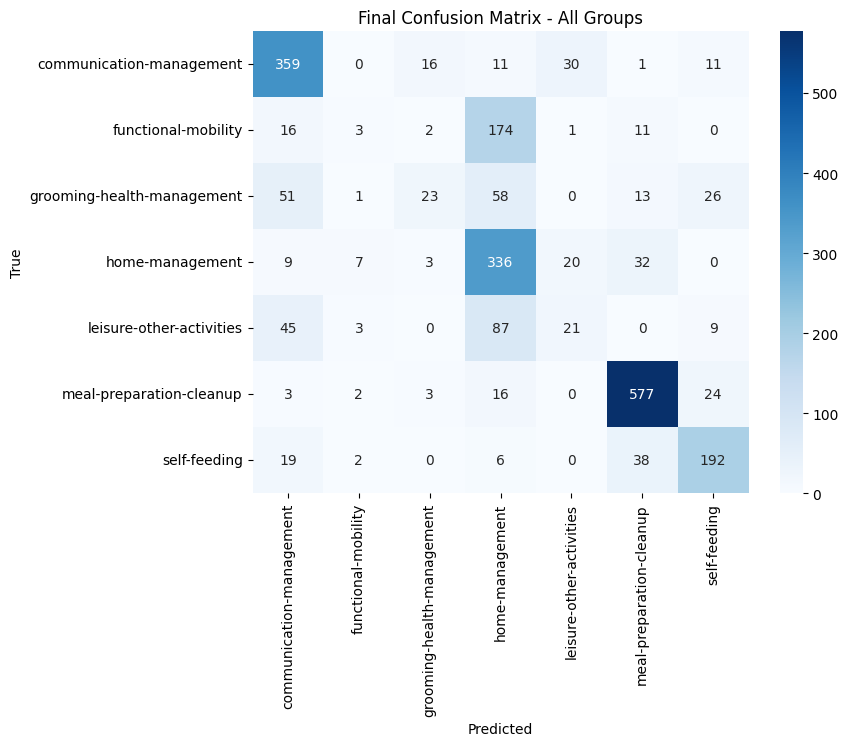

2023-11-17 22:26:18,629 - root - INFO - LOGOCV complete for RandomForestClassifier
c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:26:18,679 - root - INFO - Training complete for LogisticRegression, group left out: SCI02
c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

In

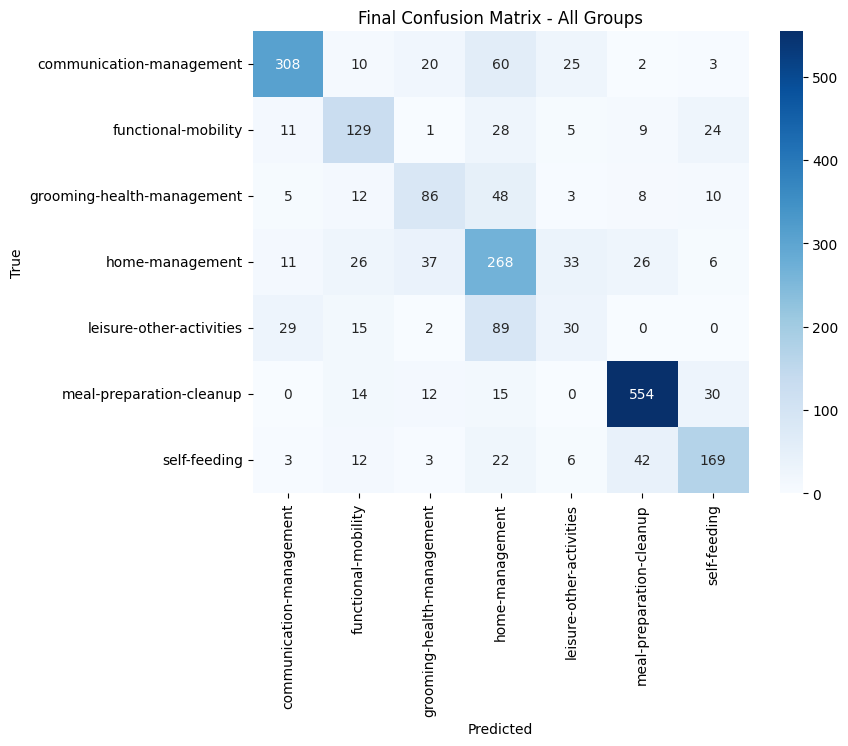

2023-11-17 22:26:19,514 - root - INFO - LOGOCV complete for LogisticRegression


In [6]:
X = df_active.drop(['adl', 'video'], axis=1)
y = df_active['adl']
groups = df_active['video'].str[:5]

# try all classifiers
rf_active = ev.leave_one_group_out_cv(df_active, X, y, groups, rf_clf)
log_active = ev.leave_one_group_out_cv(df_active, X, y, groups, log_clf)

In [7]:
# print results for each classifier
print('Random Forest Classifier')
rf_active


Random Forest Classifier


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.895833,0.866414,0.414035,0.434039,0.676471,0.642821,0.592964,0.489372
1,SCI03,0.765625,0.707090,0.561920,0.326276,0.676471,0.642821,0.592964,0.489372
2,SCI06,0.631068,0.319691,0.401299,0.911965,0.676471,0.642821,0.592964,0.489372
3,SCI08,0.571429,0.666667,0.666667,0.333333,0.676471,0.642821,0.592964,0.489372
4,SCI10,0.178899,0.474074,0.649892,0.153816,0.676471,0.642821,0.592964,0.489372
5,SCI11,0.752525,0.688078,0.392254,0.396021,0.676471,0.642821,0.592964,0.489372
6,SCI12,0.722727,0.472946,0.574768,0.775256,0.676471,0.642821,0.592964,0.489372
7,SCI13,0.672316,0.553872,0.673760,0.360431,0.676471,0.642821,0.592964,0.489372
8,SCI14,0.630435,0.643173,0.540677,0.420284,0.676471,0.642821,0.592964,0.489372
9,SCI15,0.911765,0.955926,0.647483,0.671892,0.676471,0.642821,0.592964,0.489372


In [8]:
print('Logistic Regression')
log_active

Logistic Regression


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.947917,0.908730,0.530516,0.519138,0.697566,0.531792,0.657786,0.526519
1,SCI03,0.796875,0.572523,0.677488,0.503732,0.697566,0.531792,0.657786,0.526519
2,SCI06,0.621359,0.665816,0.291775,0.587685,0.697566,0.531792,0.657786,0.526519
3,SCI08,0.571429,0.600000,0.666667,0.296296,0.697566,0.531792,0.657786,0.526519
4,SCI10,0.669725,0.380092,0.778531,0.286616,0.697566,0.531792,0.657786,0.526519
5,SCI11,0.772727,0.359084,0.579180,0.656400,0.697566,0.531792,0.657786,0.526519
6,SCI12,0.640909,0.535229,0.615291,0.531548,0.697566,0.531792,0.657786,0.526519
7,SCI13,0.451977,0.402810,0.630814,0.367653,0.697566,0.531792,0.657786,0.526519
8,SCI14,0.722826,0.566936,0.651202,0.674388,0.697566,0.531792,0.657786,0.526519
9,SCI15,0.876471,0.581679,0.707087,0.732821,0.697566,0.531792,0.657786,0.526519


### Trying XGBoost

In [9]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

2023-11-17 22:27:22,160 - root - INFO - Training complete for XGBClassifier, group left out: SCI02
2023-11-17 22:27:22,505 - root - INFO - Training complete for XGBClassifier, group left out: SCI03
2023-11-17 22:27:22,826 - root - INFO - Training complete for XGBClassifier, group left out: SCI06
2023-11-17 22:27:23,185 - root - INFO - Training complete for XGBClassifier, group left out: SCI08
2023-11-17 22:27:23,527 - root - INFO - Training complete for XGBClassifier, group left out: SCI10
2023-11-17 22:27:23,850 - root - INFO - Training complete for XGBClassifier, group left out: SCI11
2023-11-17 22:27:24,163 - root - INFO - Training complete for XGBClassifier, group left out: SCI12
2023-11-17 22:27:24,504 - root - INFO - Training complete for XGBClassifier, group left out: SCI13
2023-11-17 22:27:24,825 - root - INFO - Training complete for XGBClassifier, group left out: SCI14
2023-11-17 22:27:25,148 - root - INFO - Training complete for XGBClassifier, group left out: SCI15
2023-11-17

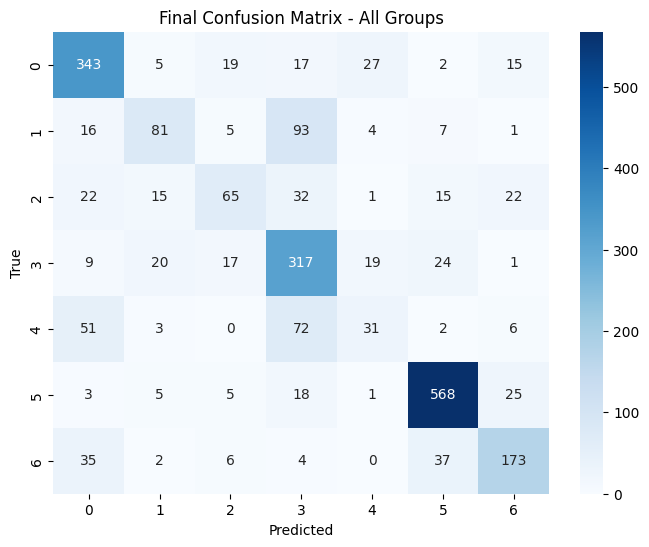

2023-11-17 22:27:27,254 - root - INFO - LOGOCV complete for XGBClassifier


XGBoost Classifier


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.916667,0.865614,0.442797,0.450728,0.698801,0.549832,0.627834,0.503456
1,SCI03,0.765625,0.508889,0.555418,0.526641,0.698801,0.549832,0.627834,0.503456
2,SCI06,0.660194,0.564613,0.450000,0.713411,0.698801,0.549832,0.627834,0.503456
3,SCI08,0.571429,0.666667,0.666667,0.333333,0.698801,0.549832,0.627834,0.503456
4,SCI10,0.490826,0.310046,0.767473,0.235652,0.698801,0.549832,0.627834,0.503456
5,SCI11,0.742424,0.400086,0.387143,0.677617,0.698801,0.549832,0.627834,0.503456
6,SCI12,0.690909,0.490958,0.562492,0.639526,0.698801,0.549832,0.627834,0.503456
7,SCI13,0.644068,0.348294,0.701379,0.426388,0.698801,0.549832,0.627834,0.503456
8,SCI14,0.722826,0.746816,0.617838,0.496206,0.698801,0.549832,0.627834,0.503456
9,SCI15,0.864706,0.467588,0.739410,0.596929,0.698801,0.549832,0.627834,0.503456


In [11]:
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=len(set(y)), eval_metric='mlogloss', random_state=SEED)
xgb_active = ev.leave_one_group_out_cv(df_active, X, y_encoded, groups, xgb_clf, xgb=True)
print('XGBoost Classifier')
xgb_active

## Without Active Objects

2023-11-17 22:17:11,995 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI02


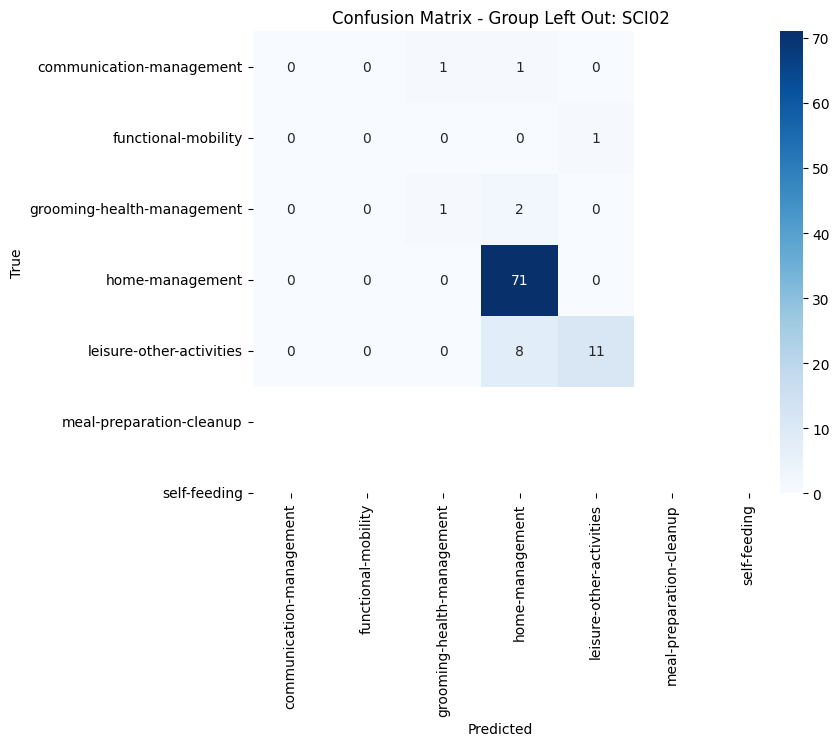

2023-11-17 22:17:13,877 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI03


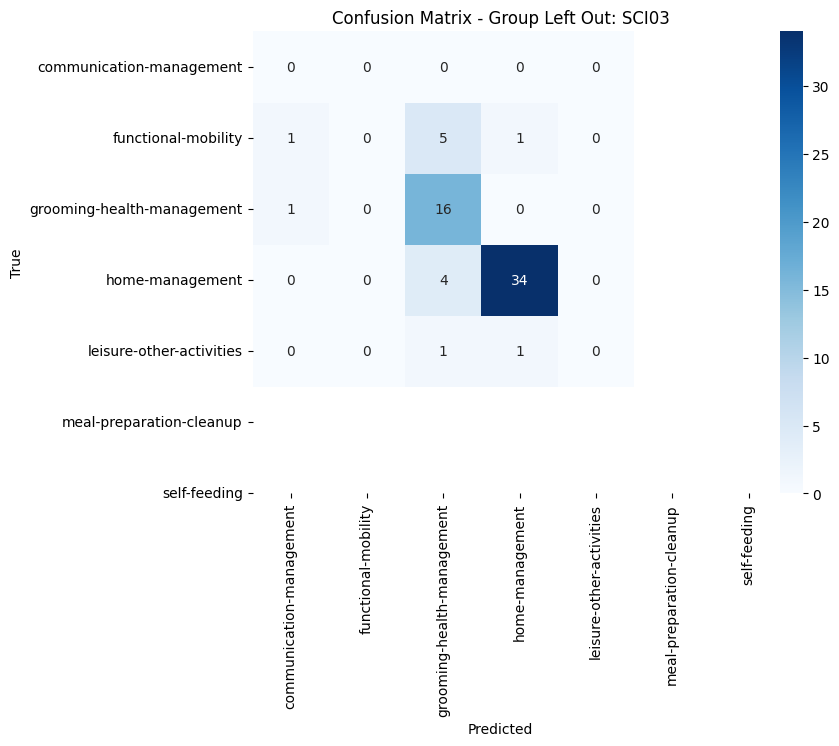

2023-11-17 22:17:15,691 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI06


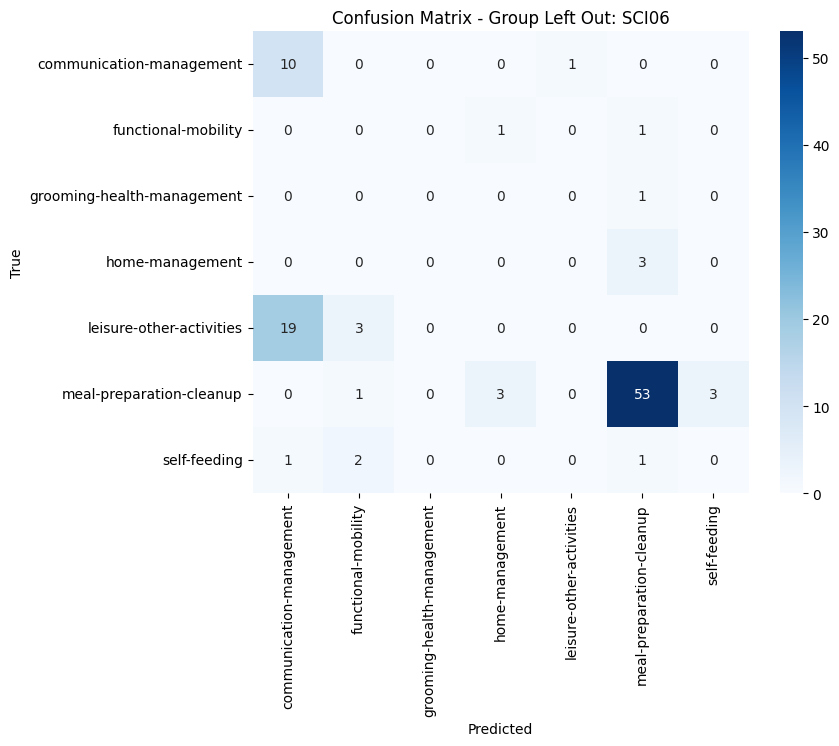

2023-11-17 22:17:17,619 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI08


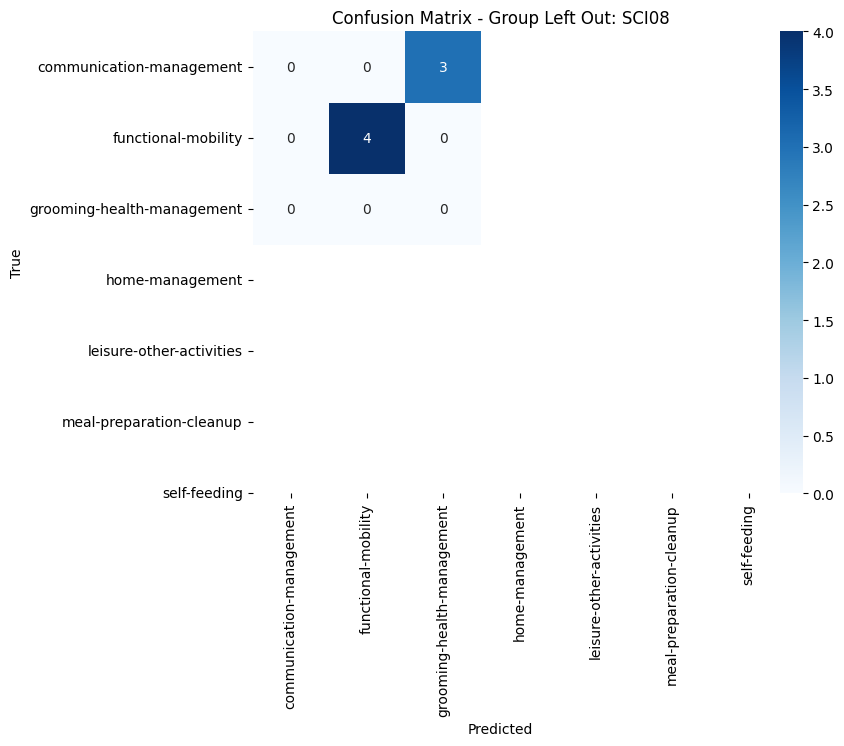

2023-11-17 22:17:19,348 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI10


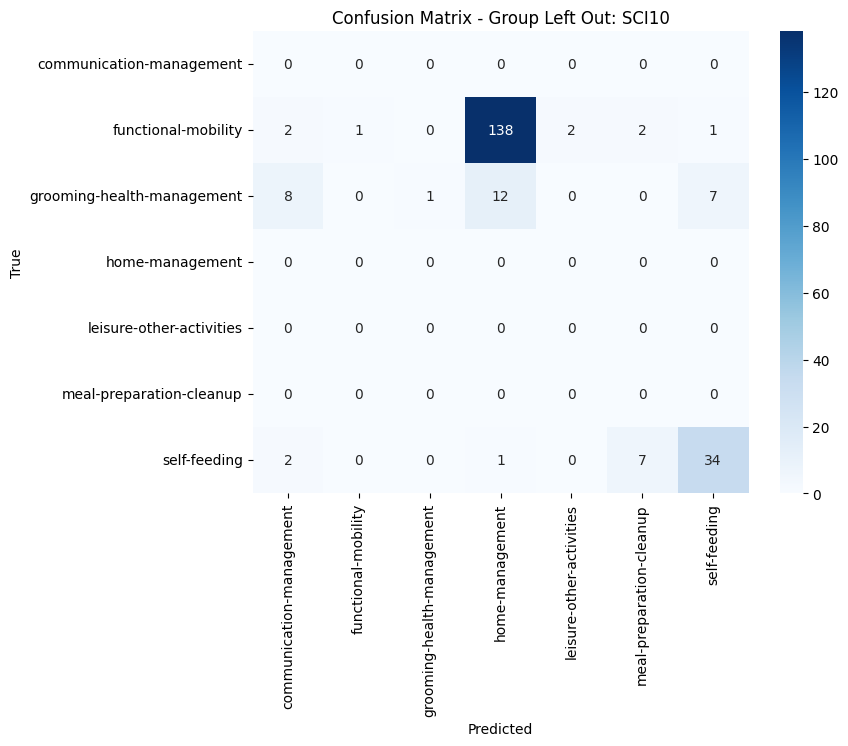

2023-11-17 22:17:21,154 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI11


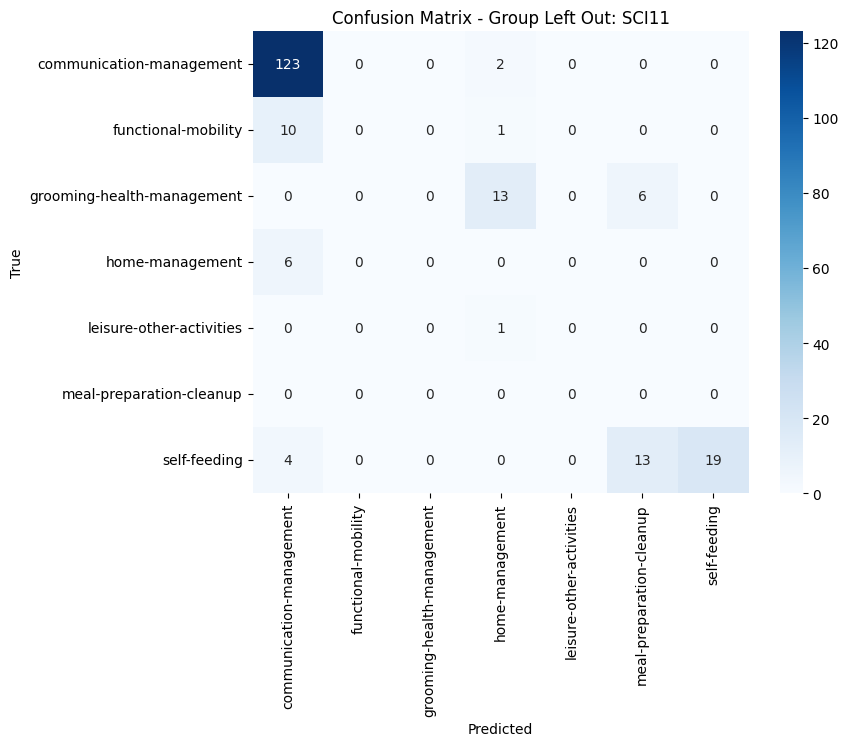

2023-11-17 22:17:22,869 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI12


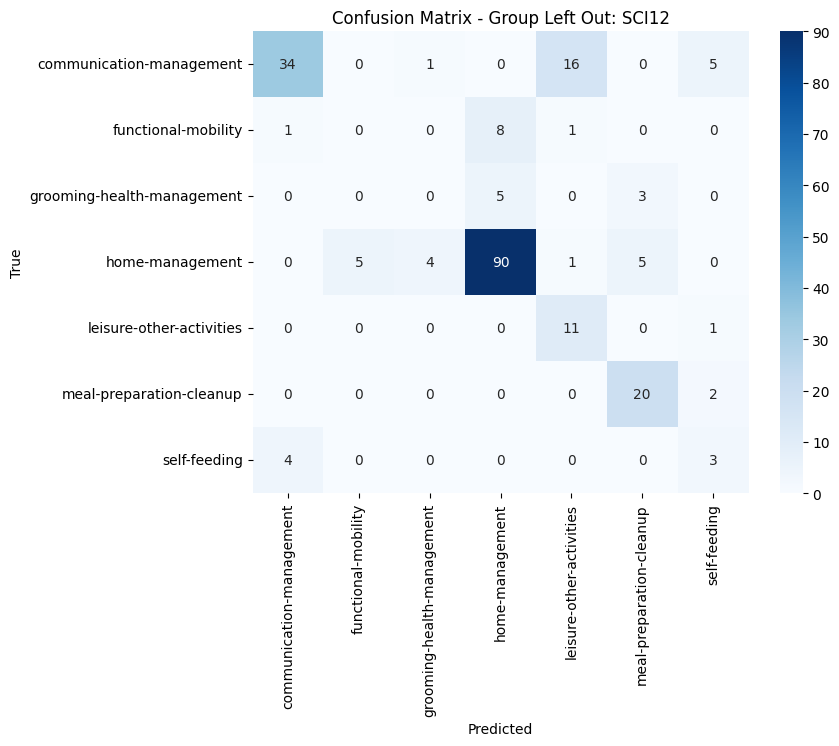

2023-11-17 22:17:24,703 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI13


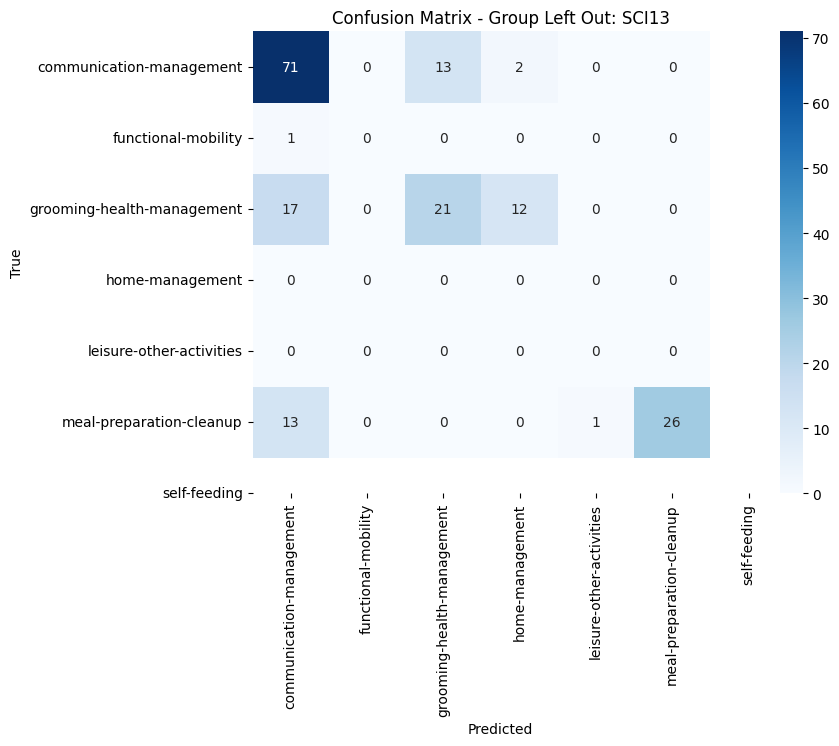

2023-11-17 22:17:26,600 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI14


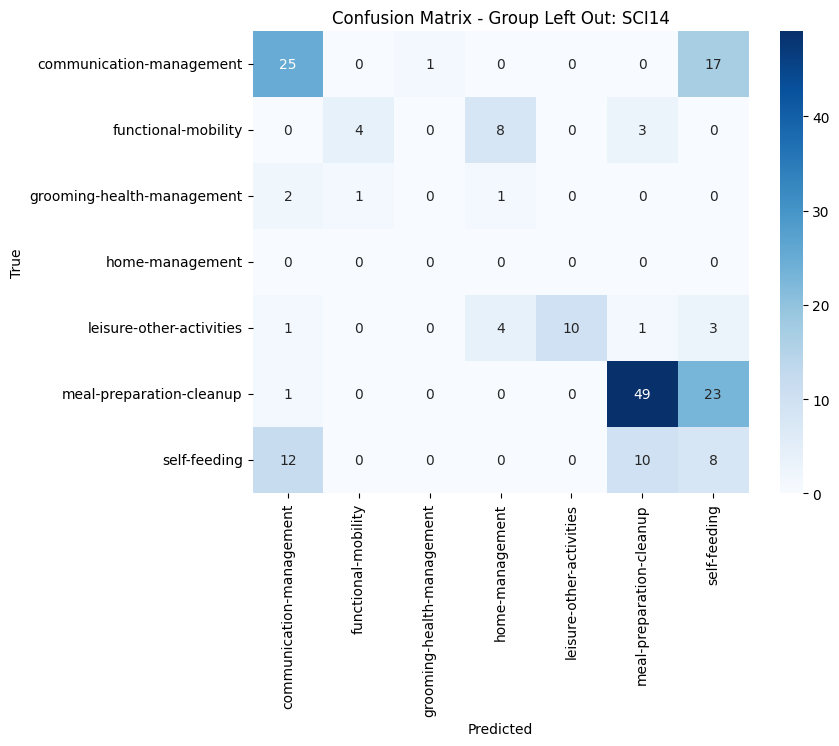

2023-11-17 22:17:28,401 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI15


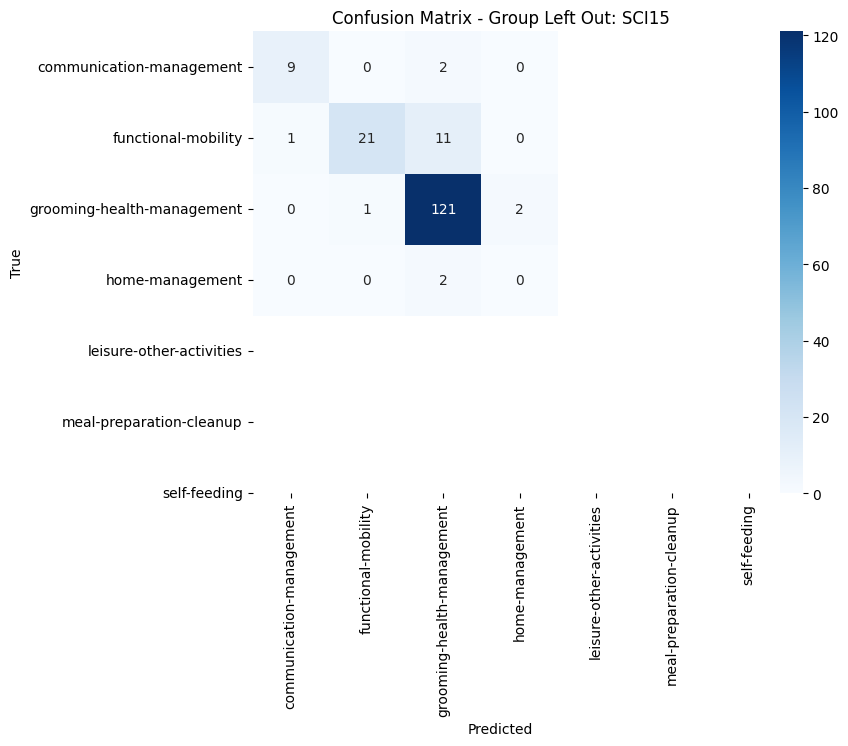

2023-11-17 22:17:30,154 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI16


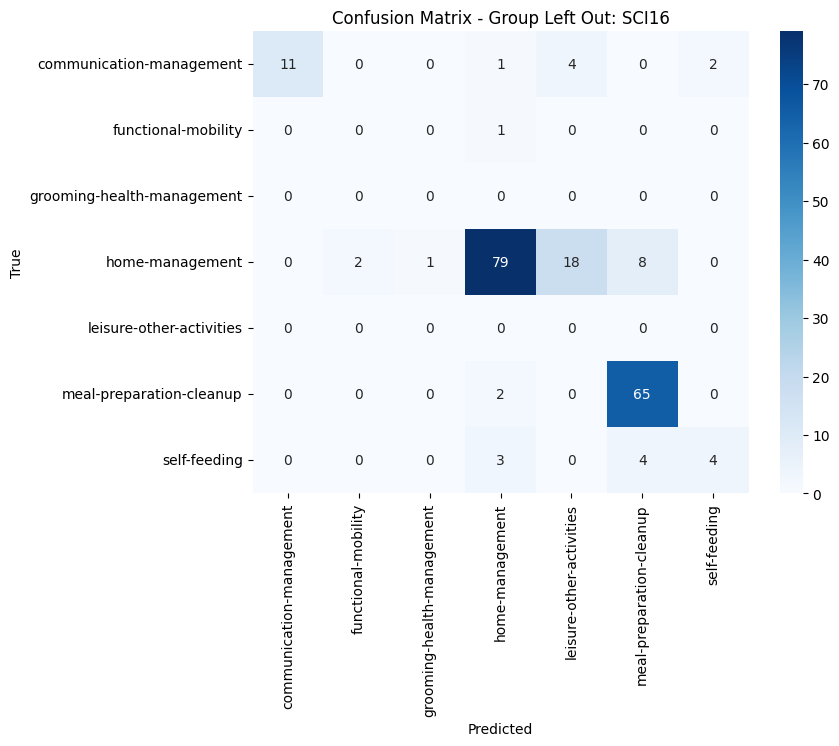

2023-11-17 22:17:31,929 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI17


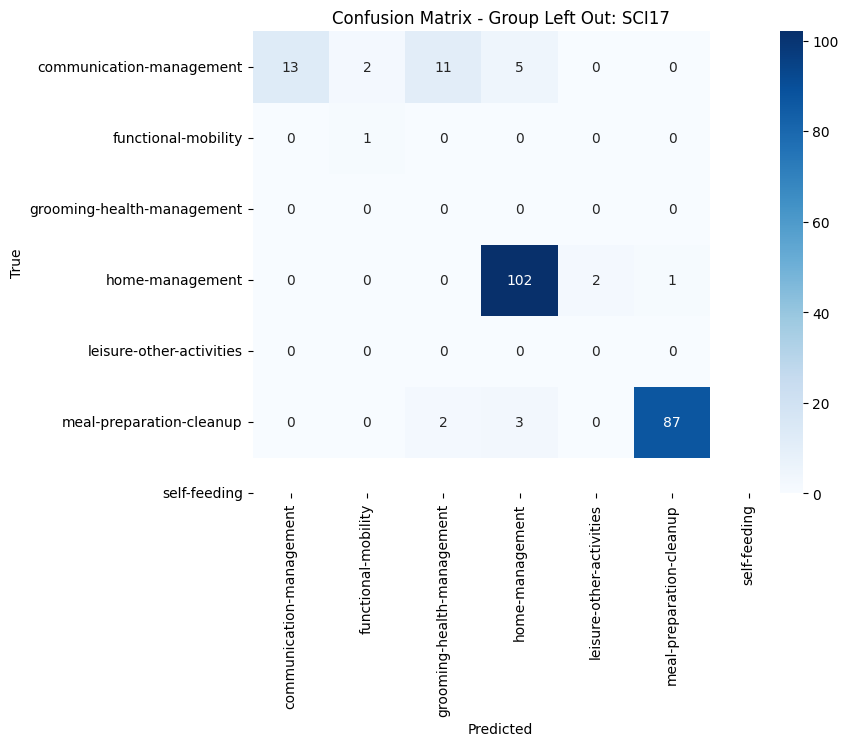

2023-11-17 22:17:33,789 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI18


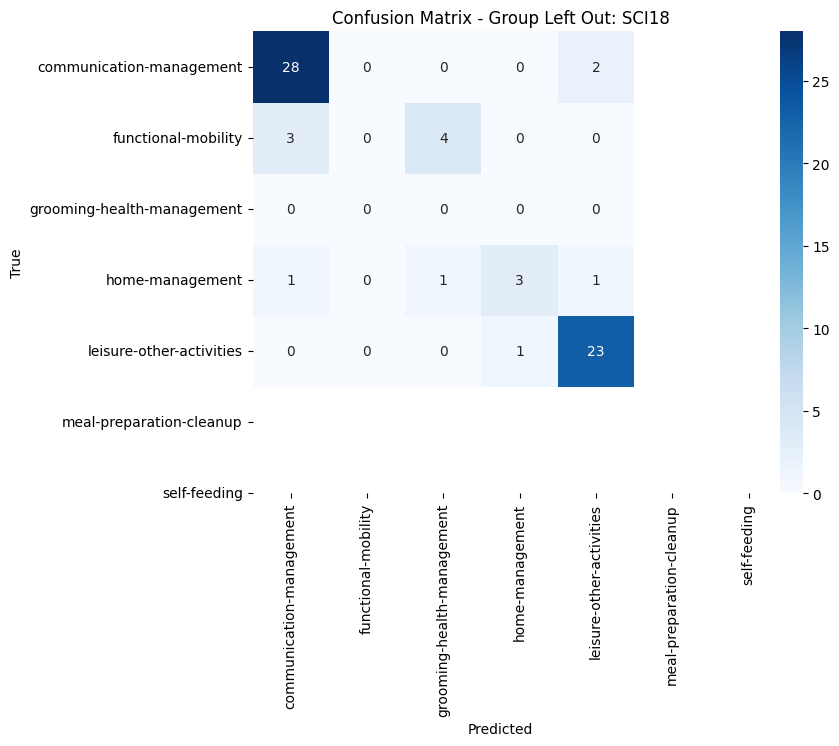

2023-11-17 22:17:35,656 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI19


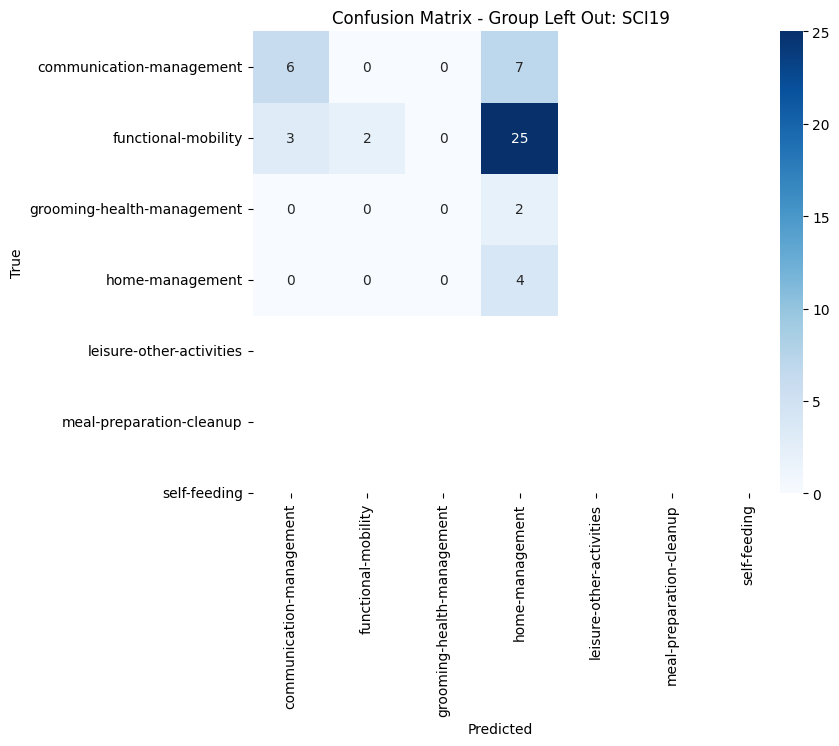

2023-11-17 22:17:37,535 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI20


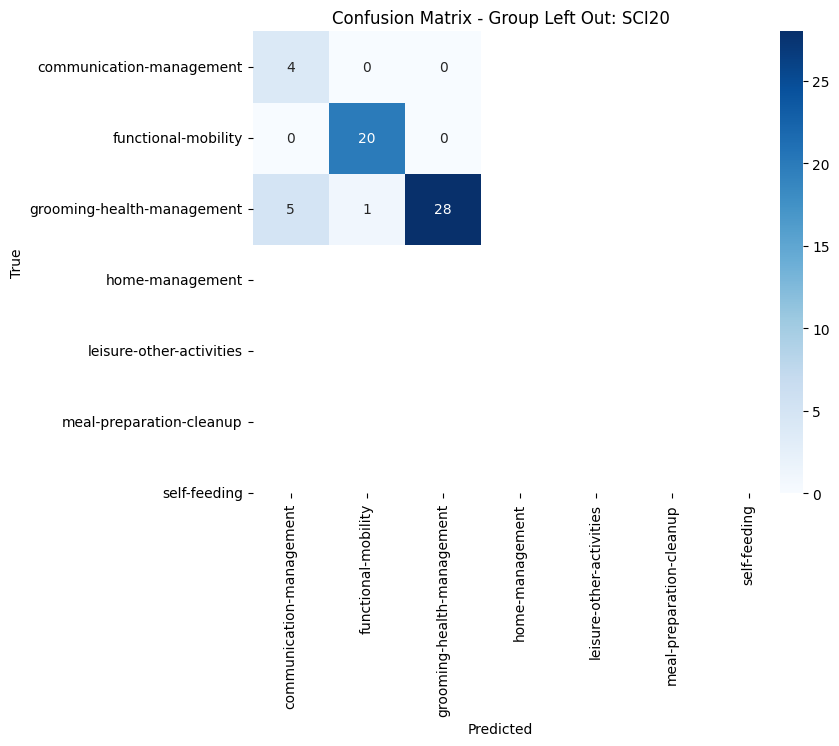

2023-11-17 22:17:39,255 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI21


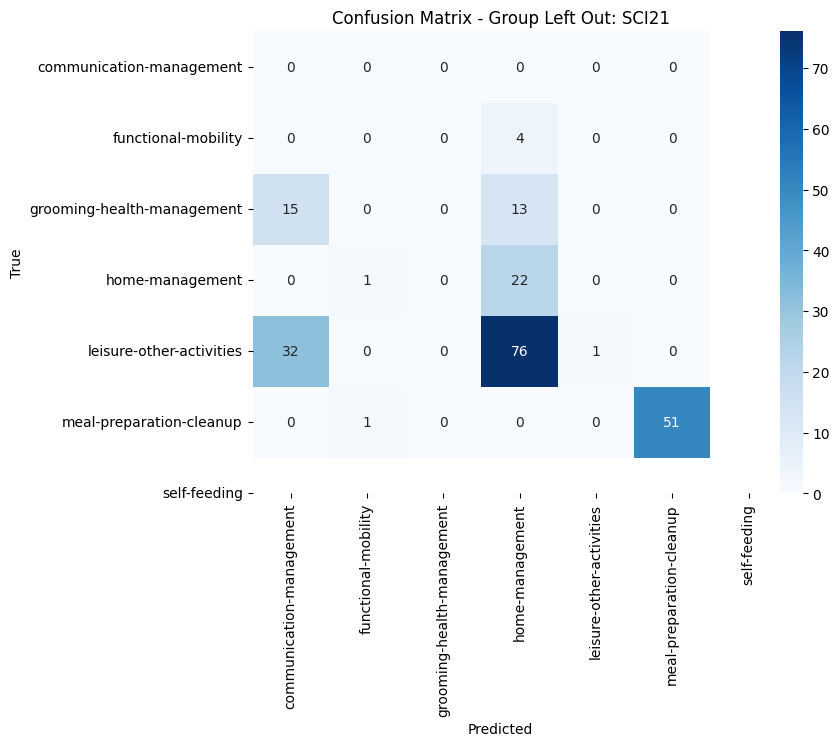

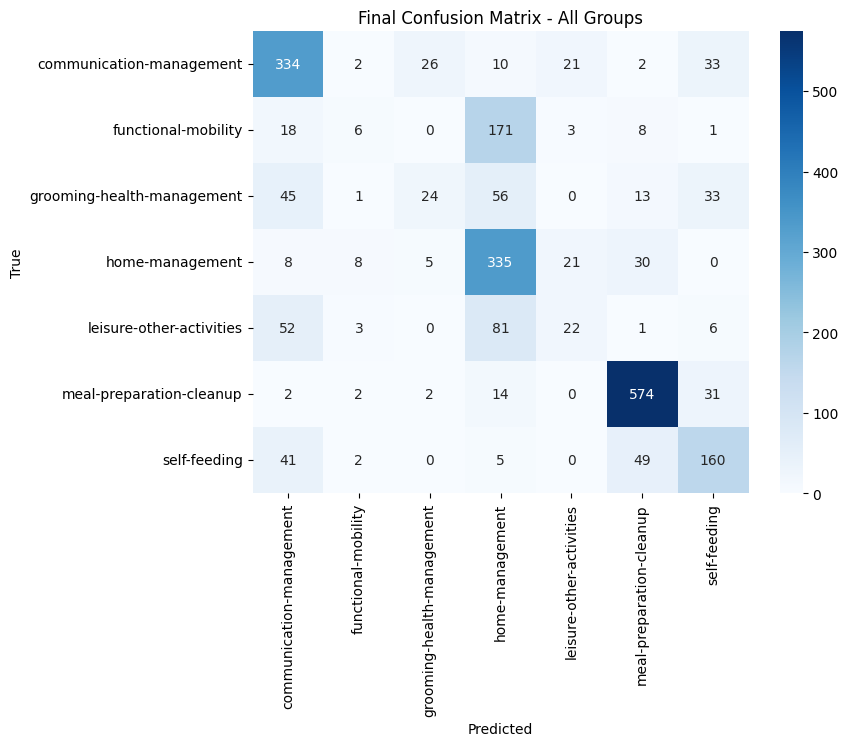

2023-11-17 22:17:39,550 - root - INFO - LOGOCV complete for RandomForestClassifier
c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:39,582 - root - INFO - Training complete for LogisticRegression, group left out: SCI02


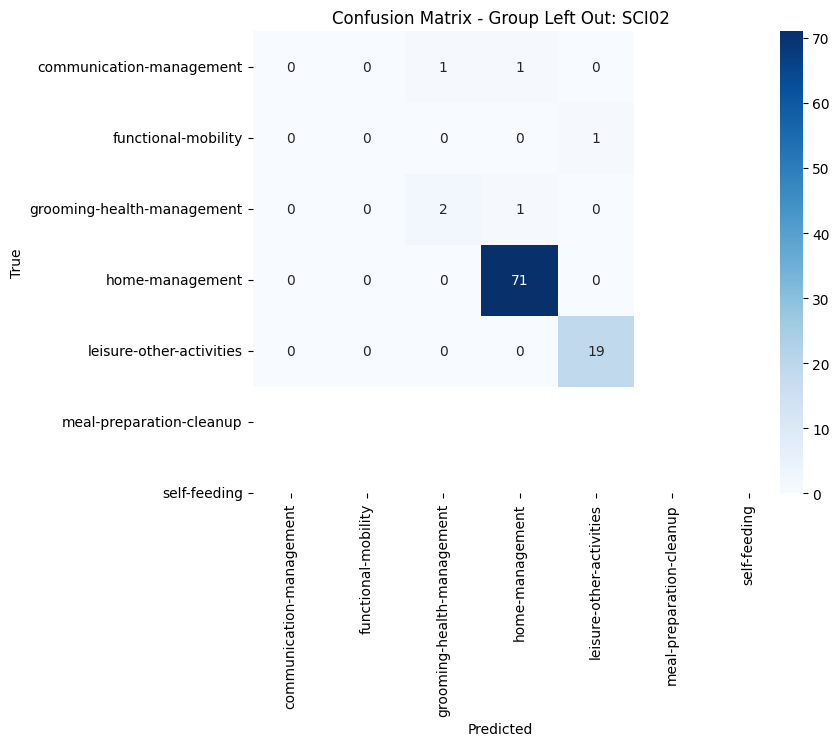

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:39,743 - root - INFO - Training complete for LogisticRegression, group left out: SCI03


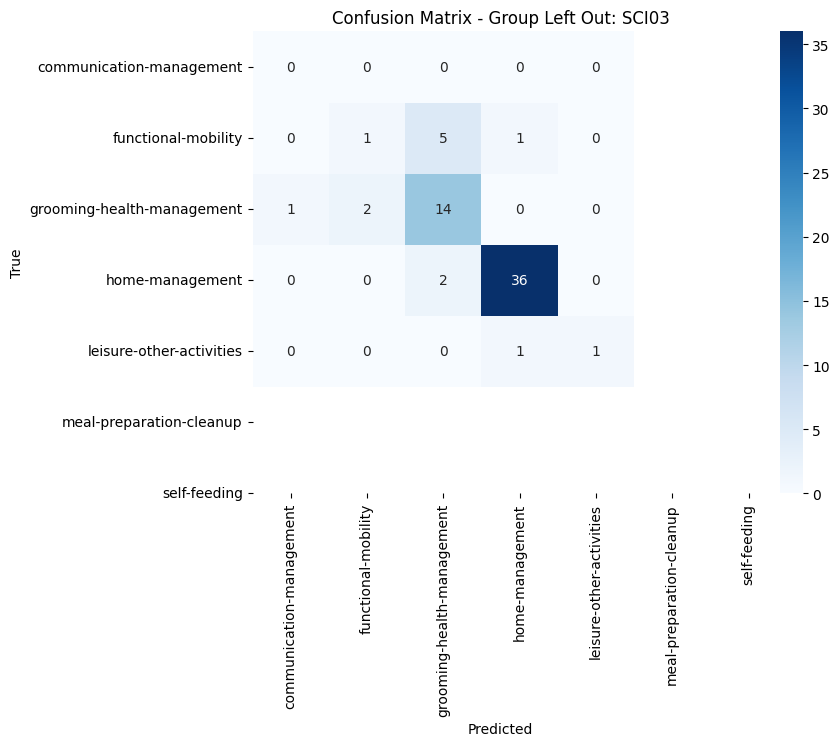

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:40,035 - root - INFO - Training complete for LogisticRegression, group left out: SCI06


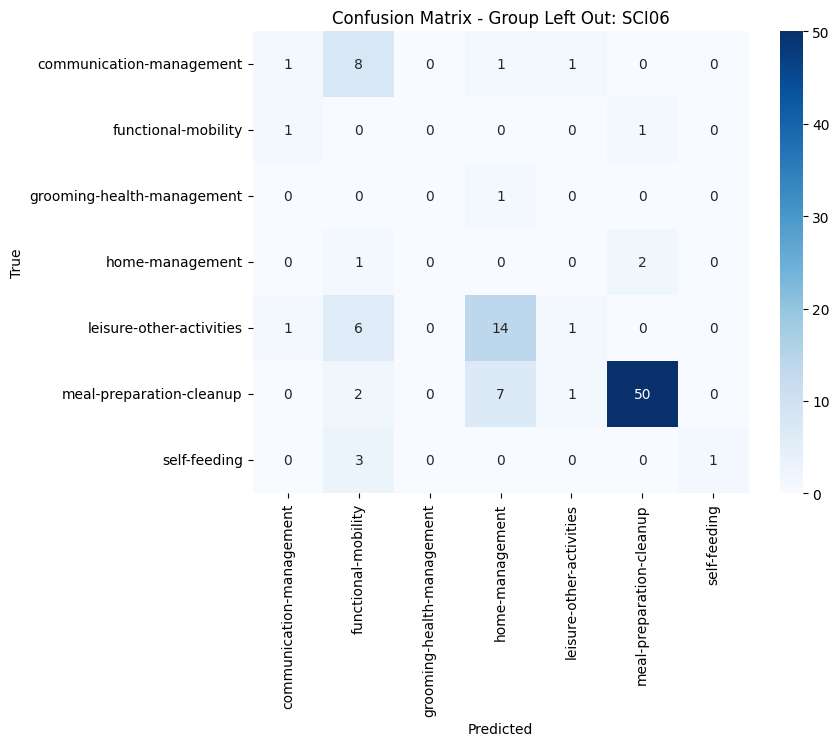

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:40,201 - root - INFO - Training complete for LogisticRegression, group left out: SCI08


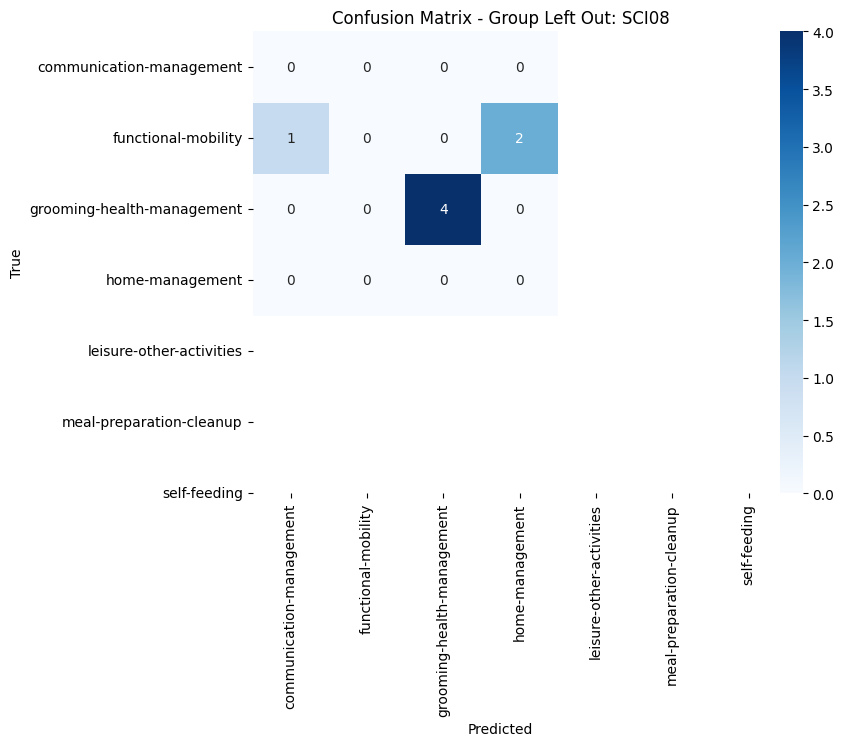

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:40,350 - root - INFO - Training complete for LogisticRegression, group left out: SCI10


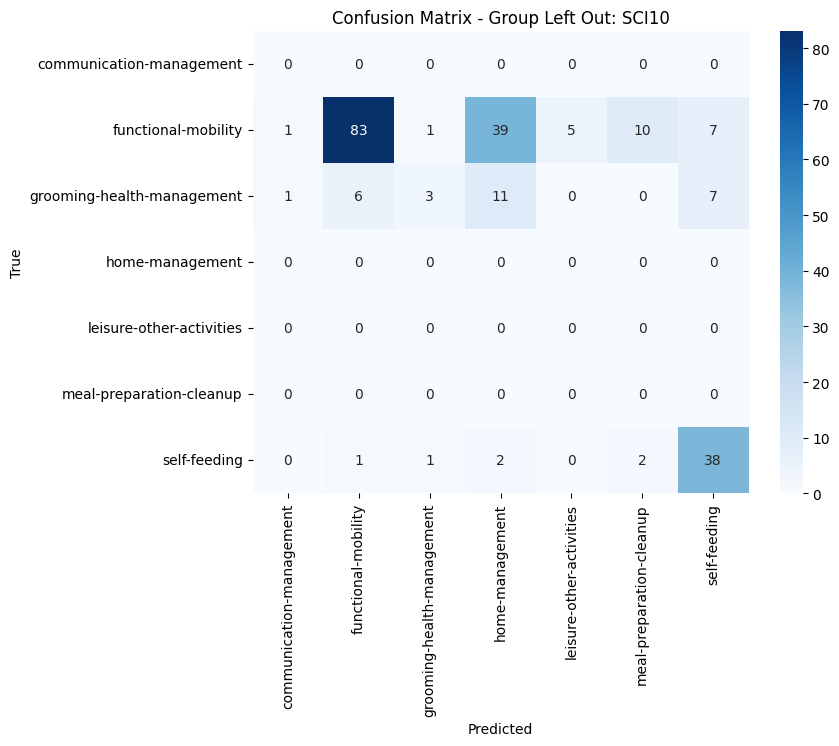

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:40,521 - root - INFO - Training complete for LogisticRegression, group left out: SCI11


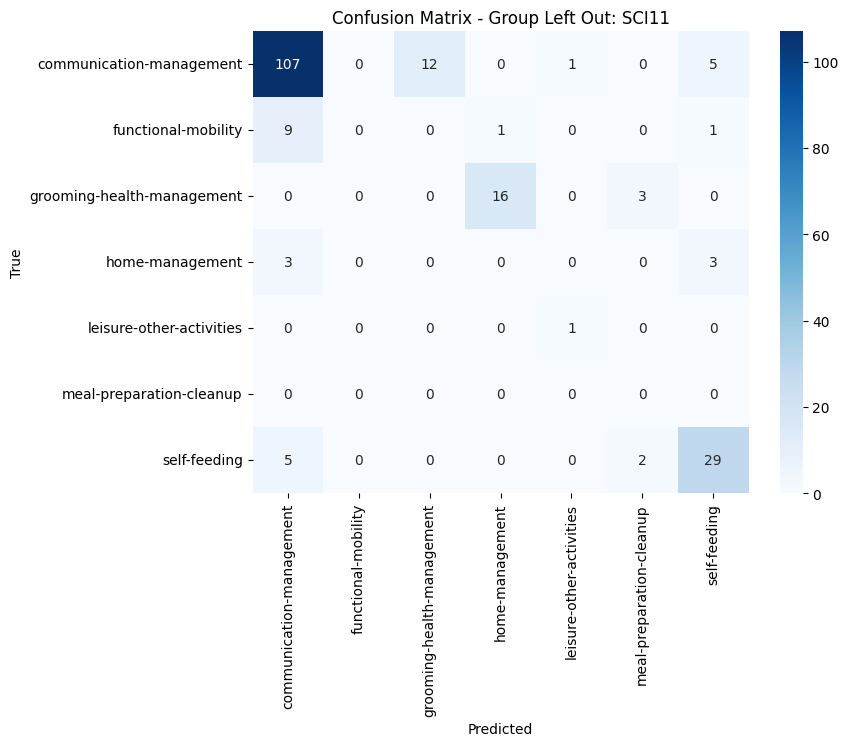

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:40,687 - root - INFO - Training complete for LogisticRegression, group left out: SCI12


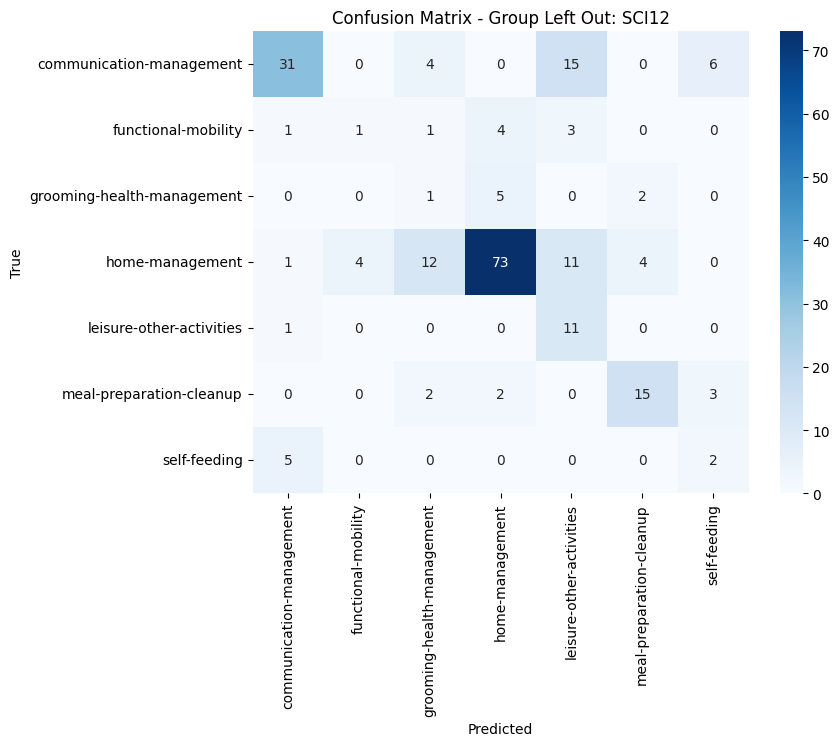

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:40,851 - root - INFO - Training complete for LogisticRegression, group left out: SCI13


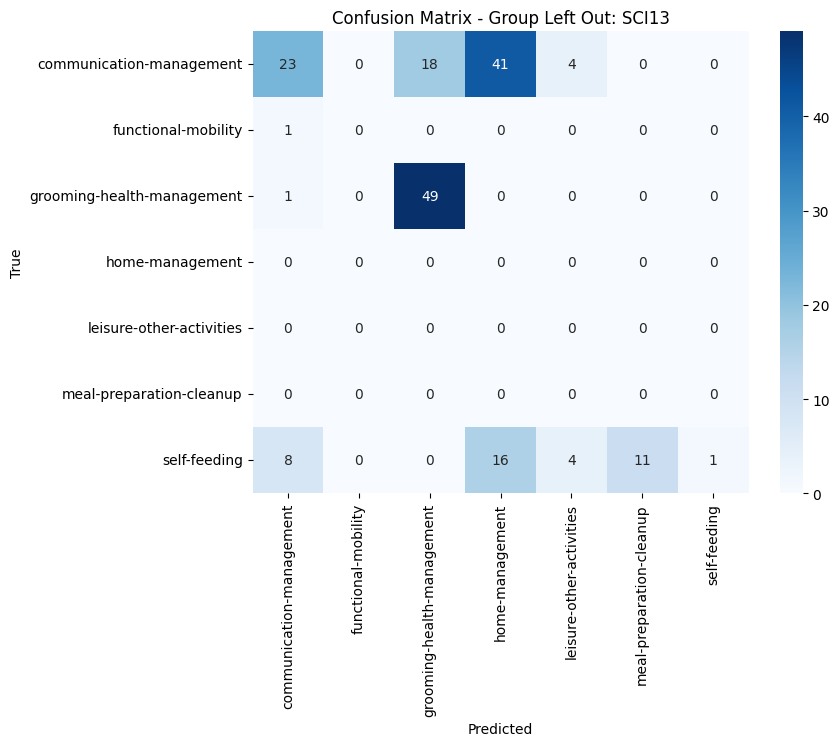

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:41,011 - root - INFO - Training complete for LogisticRegression, group left out: SCI14


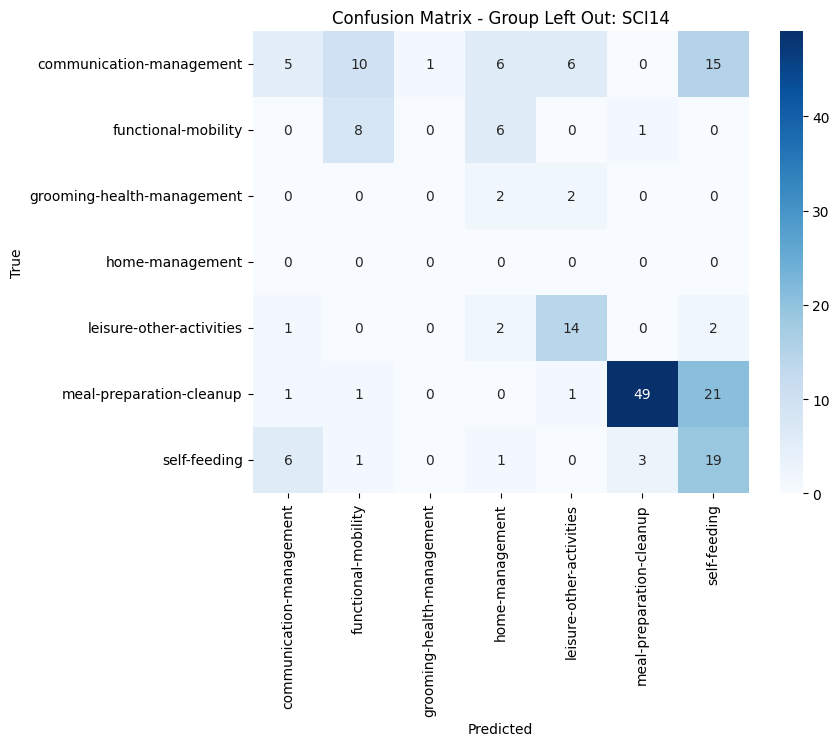

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:41,171 - root - INFO - Training complete for LogisticRegression, group left out: SCI15


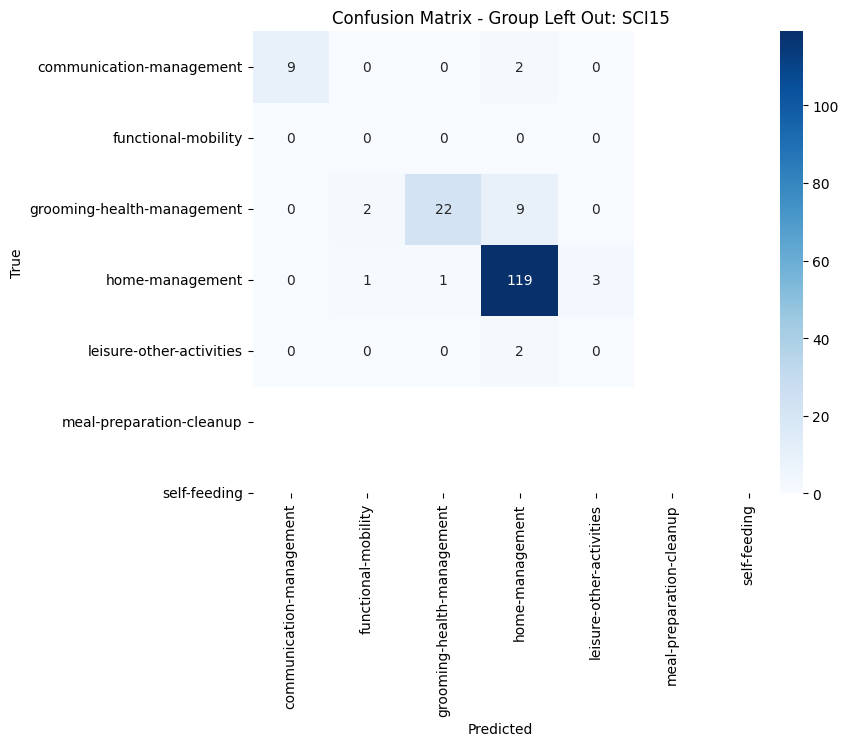

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:41,324 - root - INFO - Training complete for LogisticRegression, group left out: SCI16


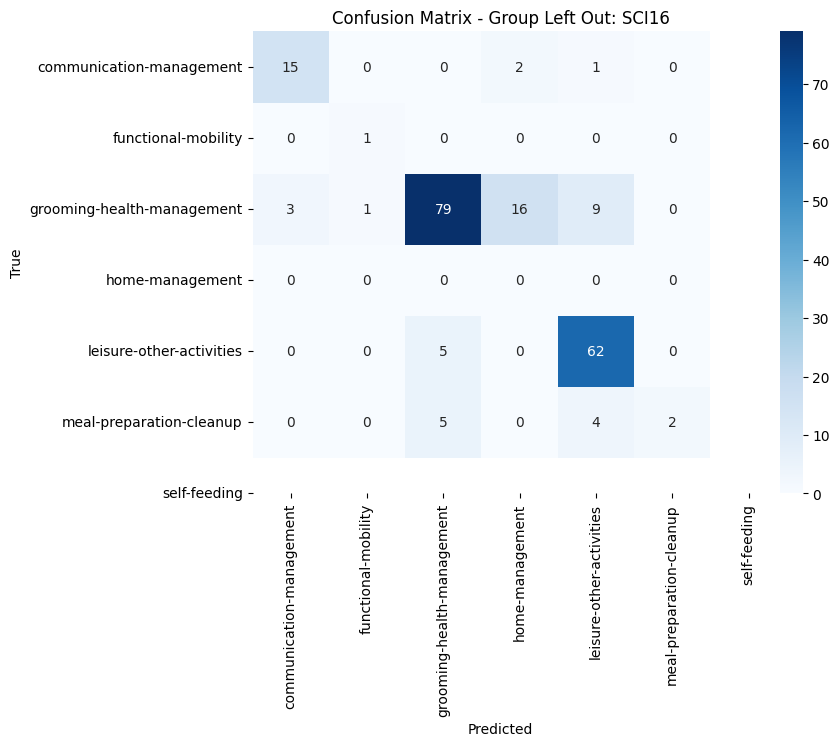

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:41,482 - root - INFO - Training complete for LogisticRegression, group left out: SCI17


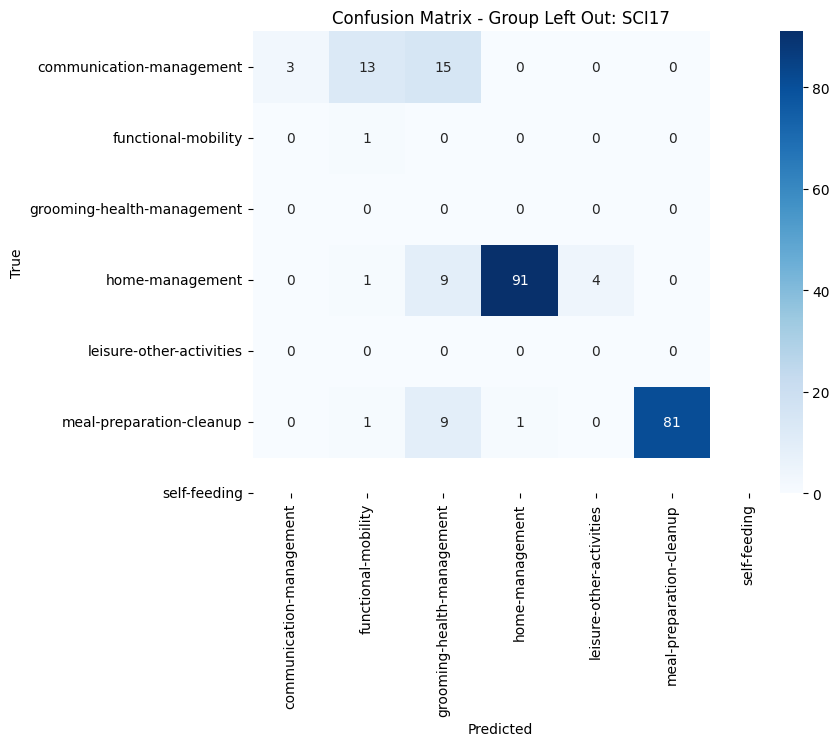

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:41,638 - root - INFO - Training complete for LogisticRegression, group left out: SCI18


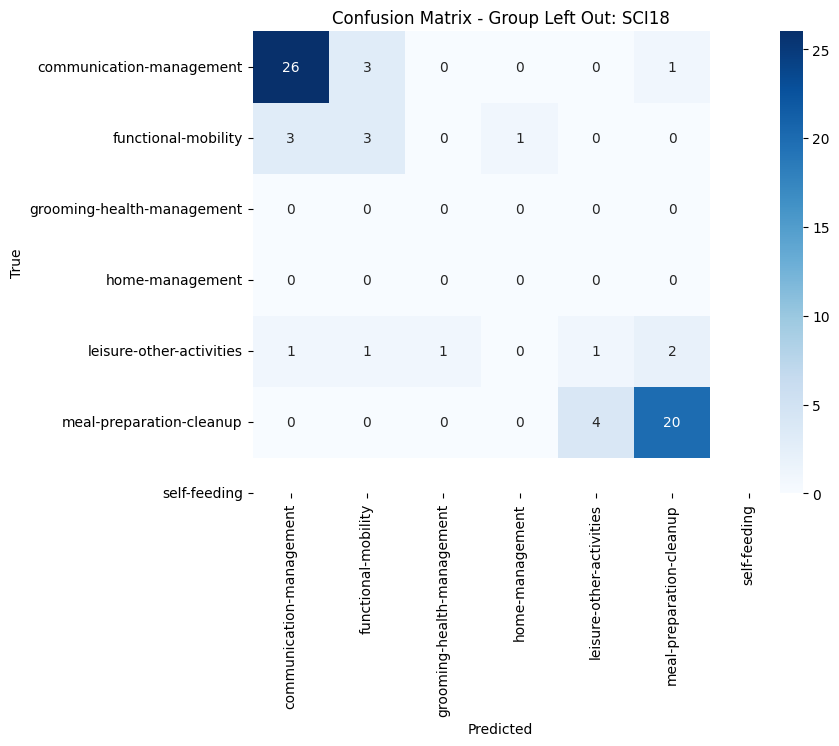

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:41,797 - root - INFO - Training complete for LogisticRegression, group left out: SCI19


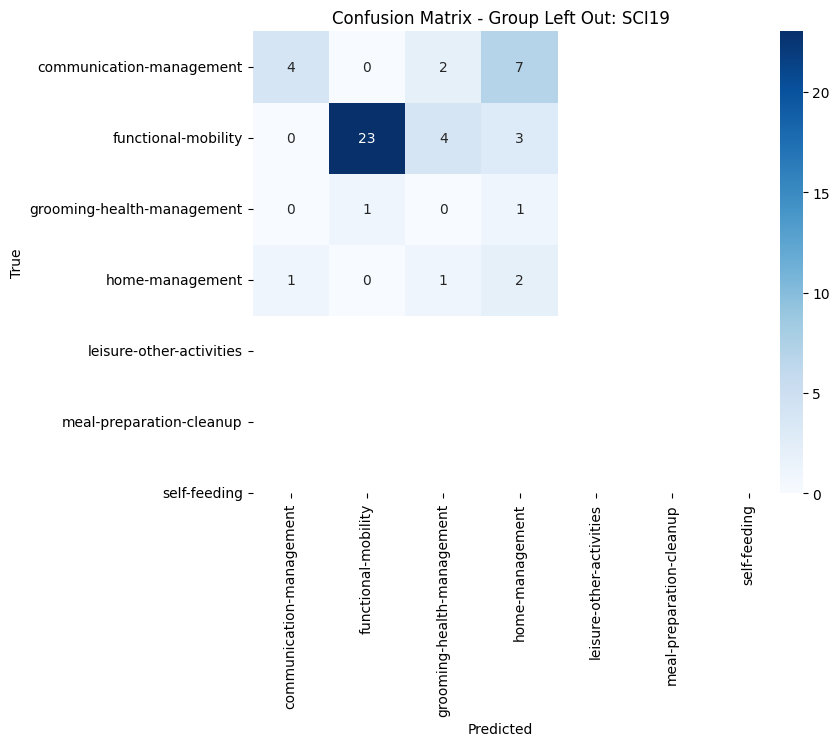

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:42,069 - root - INFO - Training complete for LogisticRegression, group left out: SCI20


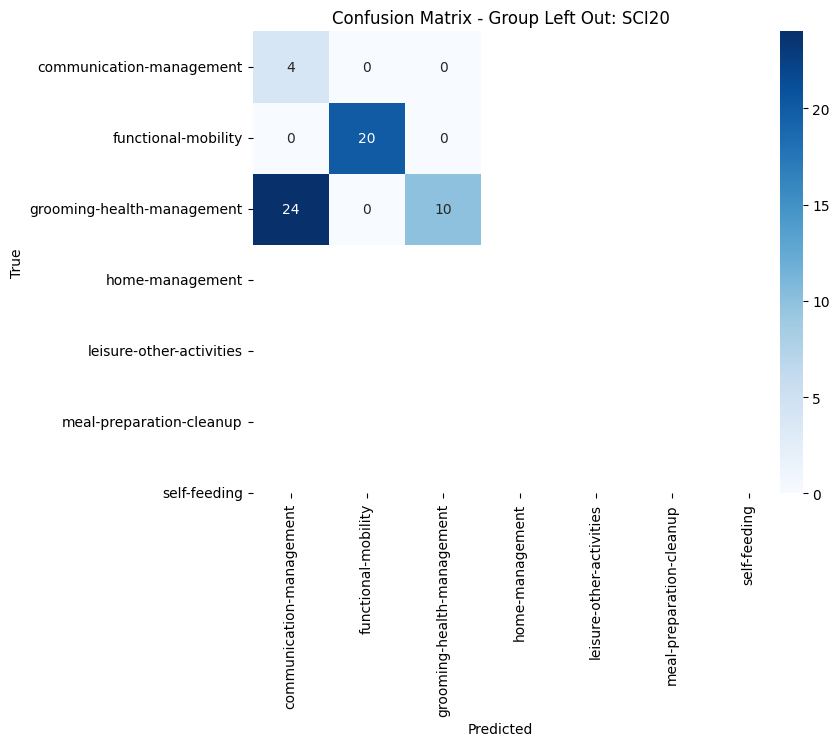

c:\Users\adesh\AppData\Local\pypoetry\Cache\virtualenvs\egovizml-XPfoP_XE-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-17 22:17:42,211 - root - INFO - Training complete for LogisticRegression, group left out: SCI21


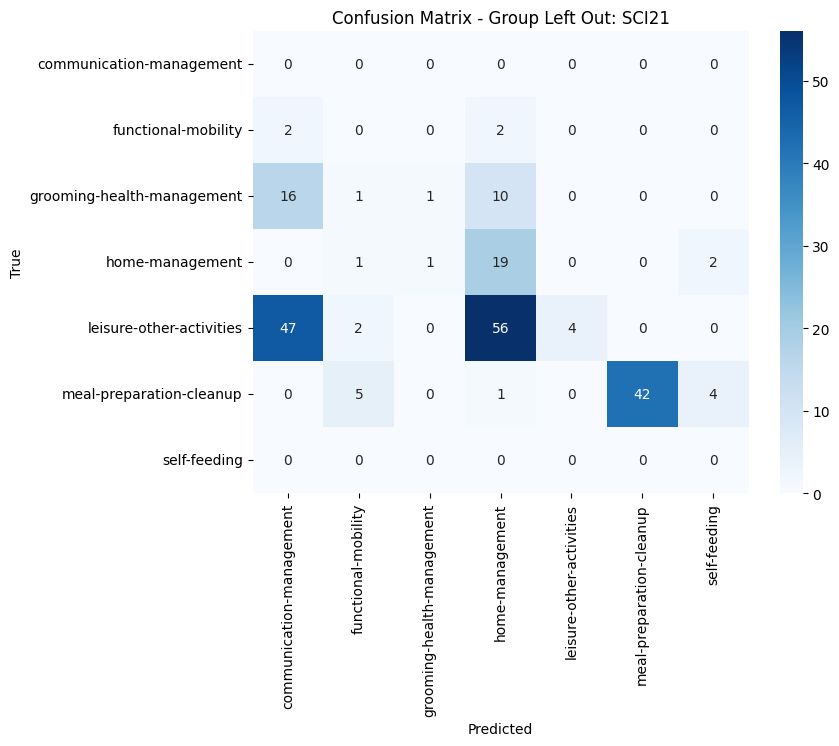

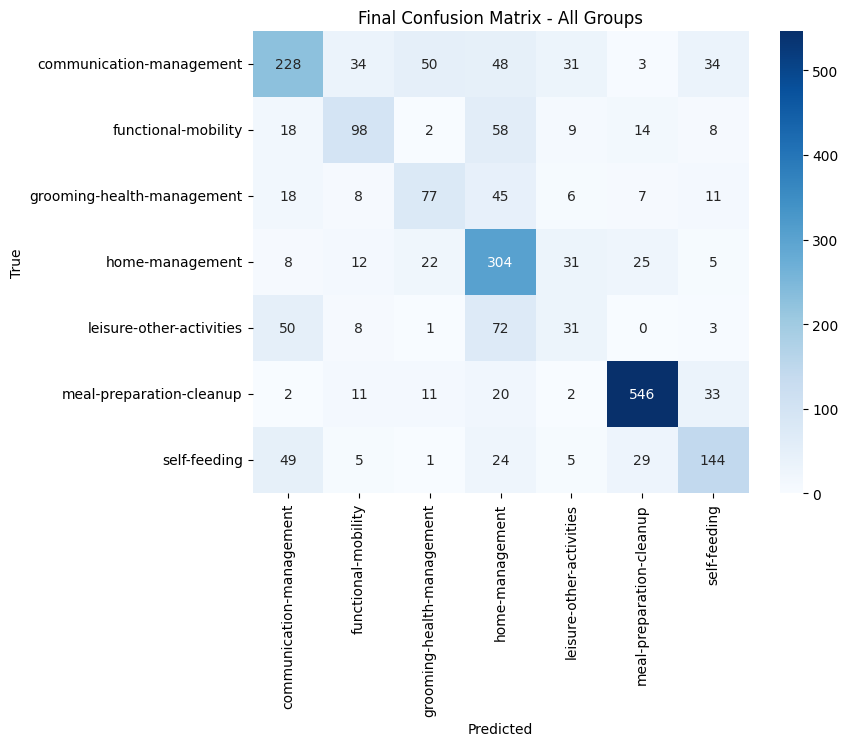

2023-11-17 22:17:42,482 - root - INFO - LOGOCV complete for LogisticRegression


In [ ]:
X = df_no_active.drop(['adl', 'video'], axis=1)
y = df_no_active['adl']
groups = df_no_active['video'].str[:5]

# try all classifiers
rf = ev.leave_one_group_out_cv(df_no_active, X, y, groups, rf_clf)
log = ev.leave_one_group_out_cv(df_no_active, X, y, groups, log_clf)

In [ ]:
# print results for each classifier
print('Random Forest Classifier')
rf

Random Forest Classifier


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.864583,0.856504,0.382456,0.407556,0.653633,0.597967,0.576903,0.488539
1,SCI03,0.781250,0.711966,0.567183,0.332621,0.653633,0.597967,0.576903,0.488539
2,SCI06,0.611650,0.318805,0.256061,0.768366,0.653633,0.597967,0.576903,0.488539
3,SCI08,0.571429,0.666667,0.666667,0.333333,0.653633,0.597967,0.576903,0.488539
4,SCI10,0.165138,0.401361,0.687899,0.124753,0.653633,0.597967,0.576903,0.488539
5,SCI11,0.717172,0.694306,0.358825,0.372689,0.653633,0.597967,0.576903,0.488539
6,SCI12,0.718182,0.444558,0.531231,0.750156,0.653633,0.597967,0.576903,0.488539
7,SCI13,0.666667,0.552288,0.649264,0.340533,0.653633,0.597967,0.576903,0.488539
8,SCI14,0.521739,0.477771,0.473182,0.514716,0.653633,0.597967,0.576903,0.488539
9,SCI15,0.888235,0.686063,0.607588,0.887887,0.653633,0.597967,0.576903,0.488539


In [ ]:
print('Logistic Regression')
log

Logistic Regression


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.958333,0.917854,0.533333,0.525427,0.644485,0.52051,0.609412,0.458795
1,SCI03,0.812500,0.589474,0.682751,0.510175,0.644485,0.52051,0.609412,0.458795
2,SCI06,0.514563,0.515723,0.174242,0.501116,0.644485,0.52051,0.609412,0.458795
3,SCI08,0.571429,0.500000,0.750000,0.250000,0.644485,0.52051,0.609412,0.458795
4,SCI10,0.568807,0.321856,0.791325,0.239554,0.644485,0.52051,0.609412,0.458795
5,SCI11,0.691919,0.446580,0.523079,0.615698,0.644485,0.52051,0.609412,0.458795
6,SCI12,0.609091,0.440718,0.479716,0.424693,0.644485,0.52051,0.609412,0.458795
7,SCI13,0.412429,0.489759,0.610349,0.181849,0.644485,0.52051,0.609412,0.458795
8,SCI14,0.516304,0.378739,0.527289,0.502420,0.644485,0.52051,0.609412,0.458795
9,SCI15,0.882353,0.571607,0.688905,0.723080,0.644485,0.52051,0.609412,0.458795
